In [101]:
!pip install missforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import pandas as pd
import numpy as np

#

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#

import seaborn as sns
import plotly.express as px

#

import os
import random
import re
import math
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback

#from pandas_summary import DataFrameSummary
#from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from keras.preprocessing import image

import warnings
import missforest
from PIL import Image
from google.colab import drive # Connect colab to google drive
warnings.filterwarnings('ignore') 
%matplotlib notebook
%matplotlib inline

In [103]:
seed_val = 101
random.seed(seed_val)
np.random.seed(seed_val)
# Setting color palette.
orange_black = [
    '#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'
]

# Setting plot styling.
plt.style.use('ggplot')

###Load Non-Image Metadata

In [104]:
drive.mount('/drive') 
%cd /drive/MyDrive/W210 - Capstone/

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/.shortcut-targets-by-id/1oLqejM9KnDiIgUupEGkxGM3_vdqboxlI/W210 - Capstone


In [105]:
df = pd.read_csv('./Data/full_data.csv', index_col = 0).rename(columns = {'duplicated': 'duplicate', 'class':'label'})
df.sample(5)

,image_id,diagnosis,age,sex,localization,source,severity,path,label,duplicate,dataset
10371,ISIC_3212050,unknown,15.0,female,torso,ISIC_2020,benign,./Data/ISIC_2020/Data/ISIC_3212050.jpg,Unclassified,False,train
15356,vasculitis-118,vasculitis photos,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Vasculitis Photos/vasculi...,Autoimmue Disorder,False,train
8144,macular-atrophy-7,lupus and other connective tissue diseases,0.0,unknown,unknown,dermnet,unknown,./Data/dermnet/train/Lupus and other Connectiv...,Unclassified,False,test
5236,ISIC_0031280,melanocytic nevi,60.0,male,foot,ISIC_2018,unknown,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole,False,train
23438,ISIC_7124408,unknown,35.0,male,torso,ISIC_2020,benign,./Data/ISIC_2020/Data/ISIC_7124408.jpg,Unclassified,False,val


In [106]:
df = df[df['duplicate'] == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62360 entries, 0 to 19558
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image_id      62360 non-null  object 
 1   diagnosis     62360 non-null  object 
 2   age           62360 non-null  float64
 3   sex           62360 non-null  object 
 4   localization  62360 non-null  object 
 5   source        62360 non-null  object 
 6   severity      62360 non-null  object 
 7   path          62360 non-null  object 
 8   label         62360 non-null  object 
 9   duplicate     62360 non-null  bool   
 10  dataset       62360 non-null  object 
dtypes: bool(1), float64(1), object(9)
memory usage: 5.3+ MB


In [107]:
df2=df.replace('unknown',np.NaN).replace(0.0, np.NaN).drop(['duplicate', 'source', 'dataset','image_id'], axis=1)
df2['diagnosis'].fillna('unknown', inplace=True)
df2.sample(5)

,diagnosis,age,sex,localization,severity,path,label
12240,unknown,50.0,female,lower extremity,benign,./Data/ISIC_2020/Data/ISIC_3766399.jpg,Unclassified
6728,nevus,50.0,male,upper extremity,benign,./Data/ISIC_2020/Data/ISIC_2109658.jpg,Benign Marking or Mole
6766,melanocytic nevi,45.0,female,lower extremity,NaN,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole
17202,unknown,65.0,male,upper extremity,benign,./Data/ISIC_2020/Data/ISIC_5252704.jpg,Unclassified
1772,unknown,65.0,male,torso,benign,./Data/ISIC_2020/Data/ISIC_0634028.jpg,Unclassified


In [108]:
train, test = train_test_split(df2, test_size=0.1)
train.shape

(56124, 7)

###Check Missing

Text(0.5, 1.0, 'Test Data Missing Values')

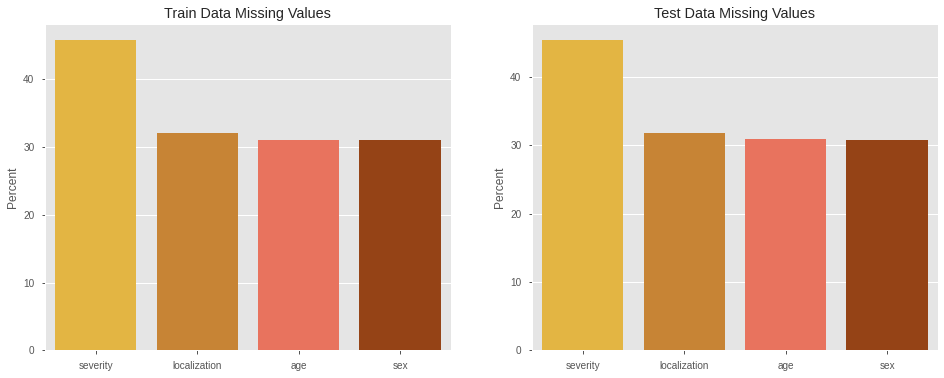

In [109]:
# Checking missing values:
def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train)
missing_test = missing_percentage(test)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            palette=orange_black,
            ax=ax[0])

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            palette=orange_black,
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

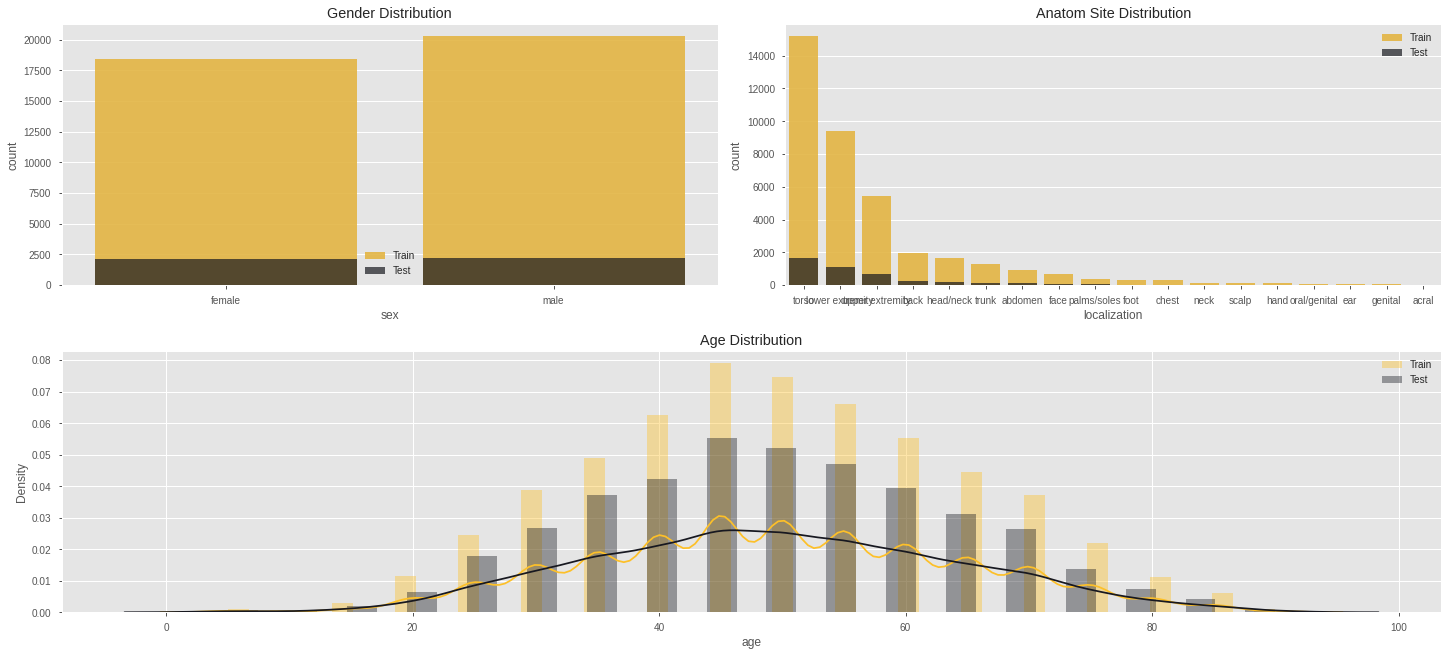

In [110]:
fig = plt.figure(constrained_layout=True, figsize=(20, 9))

# Creating a grid:

grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])

# Set the title.

ax1.set_title('Gender Distribution')

sns.countplot(train.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              color='#fdc029',
              label='Train')
sns.countplot(test.sex.sort_values(ignore_index=True),
              alpha=0.7,
              ax=ax1,
              color='#171820',
              label='Test')
ax1.legend()

# Customizing the second grid.

ax2 = fig.add_subplot(grid[0, 2:])

# Plot the countplot.

sns.countplot(train.localization,
              alpha=0.9,
              ax=ax2,
              color='#fdc029',
              label='Train',
              order=train['localization'].value_counts().index)
sns.countplot(test.localization,
              alpha=0.7,
              ax=ax2,
              color='#171820',
              label='Test',
              order=test['localization'].value_counts().index), ax2.set_title(
                  'Anatom Site Distribution')

ax2.legend()

# Customizing the third grid.

ax3 = fig.add_subplot(grid[1, :])

# Set the title.

ax3.set_title('Age Distribution')

# Plot the histogram.

sns.distplot(train.age, ax=ax3, label='Train', color='#fdc029')
sns.distplot(test.age, ax=ax3, label='Test', color='#171820')

ax3.legend()

plt.show()

###Impute Missing

In [111]:
# Filling missing anatom site values with 'unknown' tag:
# Filling missing sex values with 'unknown' tag:
# Filling missing severity values with 'unknown' tag:

for df in [train, test]:
    df['localization'].fillna('unknown', inplace=True)
    df['severity'].fillna('unknown', inplace=True)
    df['sex'].fillna('unknown', inplace=True)

In [112]:
# Filling age and sex with appropriate values.

## train['sex'].fillna(train['sex'].mode()[0], inplace=True)

train['age'].fillna(train['age'].median(), inplace=True)

In [113]:
print(
    f'Train missing value count: {train.isnull().sum().sum()}\nTest missing value count: {train.isnull().sum().sum()}'
)

Train missing value count: 0
Test missing value count: 0


###Metadata EDA

In [114]:
# Train data:

cntstr = train.localization.value_counts().rename_axis('localization').reset_index(
    name='count')

fig = px.treemap(cntstr,
                 path=['localization'],
                 values='count',
                 color='count',
                 color_continuous_scale=orange_black,
                 title='Scans by Anatom Site General Challenge - Train Data')

fig.update_traces(textinfo='label+percent entry')
fig.show()

In [115]:
# Plotting interactive sunburst:

fig = px.sunburst(data_frame=train,
                  path=['label', 'sex', 'localization'],
                  color='sex',
                  color_discrete_sequence=orange_black,
                  maxdepth=-1,
                  title='Sunburst Chart Label > Sex > Localization')

fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

In [116]:
diag = train.label.value_counts()
fig = px.pie(diag,
             values='label',
             names=diag.index,
             color_discrete_sequence=orange_black,
             hole=.4)
fig.update_traces(textinfo='percent+label', pull=0.05)
fig.show()

###Loading Image Metadata (Takes Too Long to Run)

In [117]:
#from keras.preprocessing import image

# reds = np.zeros(train.shape[0])
# greens = np.zeros(train.shape[0])
# blues = np.zeros(train.shape[0])
# mean = np.zeros(train.shape[0])
# width = np.zeros(train.shape[0], dtype=int)
# height = np.zeros(train.shape[0], dtype=int)
# for i, path in enumerate(tqdm(train['path'])):
#     img = np.array(image.load_img(path))
#     reds[i] = np.mean(img[:,:,0].ravel())
#     greens[i] = np.mean(img[:,:,1].ravel())
#     blues[i] = np.mean(img[:,:,2].ravel())
#     mean[i] = np.mean(img)
#     width[i] = img.shape[1]
#     height[i] = img.shape[0]

# train['reds'] = reds
# train['greens'] = greens
# train['blues'] = blues
# train['mean_colors'] = mean
# train['width'] = width
# train['height'] = height
# train.head()

In [118]:
train.head()

,diagnosis,age,sex,localization,severity,path,label
16939,warts molluscum and other viral infections,50.0,unknown,unknown,unknown,./Data/dermnet/train/Warts Molluscum and other...,"Toxin, Fungal, Bug, Viral, or Bacterial Infect..."
15302,vasculitis photos,50.0,unknown,unknown,unknown,./Data/dermnet/train/Vasculitis Photos/vasculi...,Autoimmue Disorder
6424,melanocytic nevi,35.0,male,foot,unknown,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole
23514,unknown,60.0,male,torso,benign,./Data/ISIC_2020/Data/ISIC_7144643.jpg,Unclassified
1339,dermatofibroma,55.0,female,lower extremity,unknown,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,Benign Marking or Mole


###Getting ready to model

In [119]:
# getting dummy variables for gender on train set

sex_dummies = pd.get_dummies(train['sex'], prefix='sex')
train = pd.concat([train, sex_dummies], axis=1)

# getting dummy variables for gender on test set

sex_dummies = pd.get_dummies(test['sex'], prefix='sex')
test = pd.concat([test, sex_dummies], axis=1)

# getting dummy variables for location on train set

anatom_dummies = pd.get_dummies(train['localization'], prefix='anatom')
train = pd.concat([train, anatom_dummies], axis=1)

# getting dummy variables for location on test set

anatom_dummies = pd.get_dummies(test['localization'], prefix='anatom')
test = pd.concat([test, anatom_dummies], axis=1)

# dropping not useful columns

train.drop(['sex','diagnosis','severity','path', 'localization'], axis=1, inplace=True)
test.drop(['sex','diagnosis','severity','path', 'localization'], axis=1, inplace=True)


In [120]:
train.head()

,age,label,sex_female,sex_male,sex_unknown,anatom_abdomen,anatom_acral,anatom_back,anatom_chest,anatom_ear,...,anatom_head/neck,anatom_lower extremity,anatom_neck,anatom_oral/genital,anatom_palms/soles,anatom_scalp,anatom_torso,anatom_trunk,anatom_unknown,anatom_upper extremity
16939,50.0,"Toxin, Fungal, Bug, Viral, or Bacterial Infect...",0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15302,50.0,Autoimmue Disorder,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6424,35.0,Benign Marking or Mole,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23514,60.0,Unclassified,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1339,55.0,Benign Marking or Mole,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [123]:
#create a mapping from labels to a unique integer and vice versa for labelling and prediction later
labels = train['label'].unique()
i = 0
idx2class = {} 
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i += 1
idx2class

{0: 'Toxin, Fungal, Bug, Viral, or Bacterial Infections',
 1: 'Autoimmue Disorder',
 2: 'Benign Marking or Mole',
 3: 'Unclassified',
 4: 'Potentially Malignant Skin Tumors',
 5: 'Non-Cancerous Skin Condition'}

In [124]:
train['label'] = train['label'].replace(class2idx)
train.head()

,age,label,sex_female,sex_male,sex_unknown,anatom_abdomen,anatom_acral,anatom_back,anatom_chest,anatom_ear,...,anatom_head/neck,anatom_lower extremity,anatom_neck,anatom_oral/genital,anatom_palms/soles,anatom_scalp,anatom_torso,anatom_trunk,anatom_unknown,anatom_upper extremity
16939,50.0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
15302,50.0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6424,35.0,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23514,60.0,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1339,55.0,2,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [125]:
test['label'] = test['label'].replace(class2idx)
test.head()

,age,label,sex_female,sex_male,sex_unknown,anatom_abdomen,anatom_acral,anatom_back,anatom_chest,anatom_ear,...,anatom_head/neck,anatom_lower extremity,anatom_neck,anatom_oral/genital,anatom_palms/soles,anatom_scalp,anatom_torso,anatom_trunk,anatom_unknown,anatom_upper extremity
9070,80.0,2,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29047,45.0,2,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8061,35.0,2,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9336,5.0,2,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24177,50.0,3,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


###Cross Validate on Accuracy

In [133]:
# loading modelling libraries

import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [126]:
X = train.drop('label', axis=1)
y = train.label

In [127]:
# taking holdout set for validating with stratified y

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# 5 fold stratify for cv

cv = StratifiedKFold(5, shuffle=True, random_state=42)

In [128]:
# setting model hyperparameters, didn't include fine tuning here because of timing reasons...

xg = xgb.XGBClassifier(
    n_estimators=750,
    min_child_weight=0.81,
    learning_rate=0.025,
    max_depth=2,
    subsample=0.80,
    colsample_bytree=0.42,
    gamma=0.10,
    random_state=42,
    n_jobs=-1,
)

In [129]:
estimators = [xg]

In [130]:
# cross validation scheme

def model_check(X_train, y_train, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    scoring='accuracy',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index,
                        'Train accuracy'] = cv_results['train_score'].mean()
        model_table.loc[row_index,
                        'Validation accuracy'] = cv_results['test_score'].mean()
        model_table.loc[row_index, 'Validation Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Validation accuracy'],
                            ascending=False,
                            inplace=True)

    return model_table

In [131]:
# display cv results

raw_models = model_check(X_train, y_train, estimators, cv)
display(raw_models)

,Model Name,Train accuracy,Test accuracy,Test Std,Time
0,XGBClassifier,0.635688,0.635538,0.004205,84.88353


In [137]:
# fitting train data

xg.fit(X, y)

# predicting on holdout set
holdout = xg.predict(test)

# checking results on test set
accuracy_score(y_test, holdout)

0.6331403118040089

###Model Result on Test Data

In [139]:
train_X = train.drop('label', axis=1)
train_y = train.label

test_X = test.drop('label', axis=1)
test_y = test.label

In [140]:
xg.fit(train_X, train_y)

# predicting on holdout set
prediction = xg.predict(test_X)

# checking results on test set
accuracy_score(test_y, prediction)

0.5886786401539449

###Feature Importance

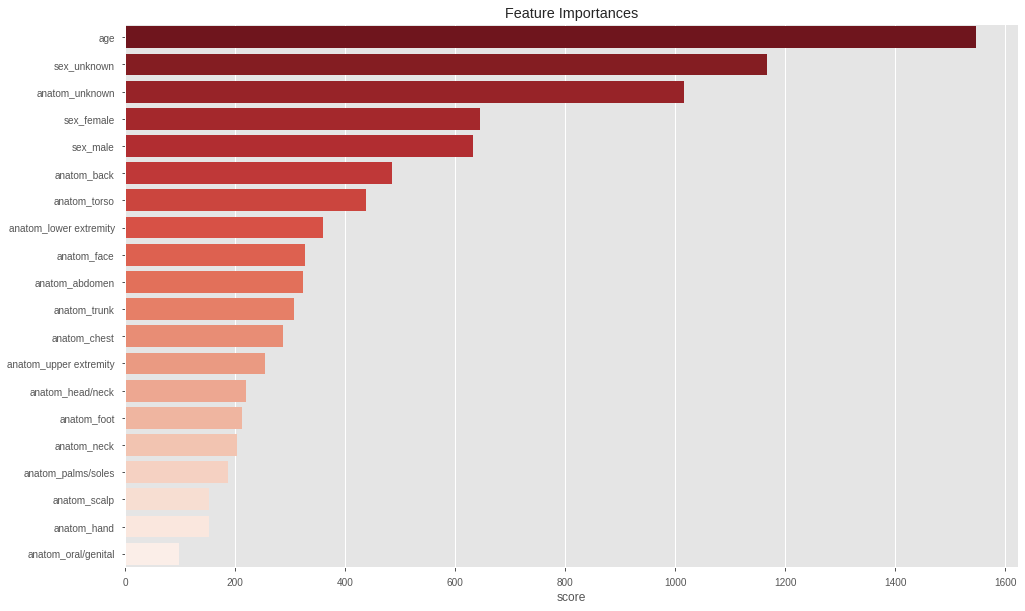

In [141]:
# finding feature importances and creating new dataframe basen on them

feature_importance = xg.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)
fig, ax = plt.subplots(figsize=(16, 10))
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r')
ax.set_title('Feature Importances')
plt.show()